In [1]:
import torch
from torch.utils import data
from torch import nn, distributions

import math

from pytorch_metric_learning.distances import LpDistance

import matplotlib.pyplot as plt
import scienceplots

import gc
import numpy as np

generator = torch.Generator()
generator.manual_seed(42)
import matplotlib as mpl

mpl.rcParams["image.cmap"] = "magma"

In [2]:
def hard_contrastive_loss_fn(pwz, pwy, mask):
    loss = torch.zeros_like(pwz).to(pwz)
    loss[mask] = pwz[mask]
    loss[~mask] = torch.relu(pwy[~mask] - pwz[~mask])
    return loss


def soft_contrastive_loss_fn(pwz, pwy, mask, threshold):
    loss = torch.zeros_like(pwz).to(pwz)
    max_z_threshold = torch.maximum(pwz, torch.ones(*loss.size()).fill_(threshold))
    min_z_threshold = torch.minimum(pwz, torch.ones(*loss.size()).fill_(threshold))
    loss[mask] = max_z_threshold[mask].div(threshold) * (
        min_z_threshold[mask] - pwy[mask]
    )
    loss[~mask] = (2 - min_z_threshold[~mask].div(threshold)) * (
        pwy[~mask] - max_z_threshold[~mask]
    )

    loss = torch.relu(loss)
    return loss


def contrastive_loss(z, y, threshold, soft=False, reduction="mean"):
    z_metric = LpDistance(normalize_embeddings=False, p=2, power=1)
    y_metric = LpDistance(normalize_embeddings=False, p=2, power=1)
    pwz = z_metric(z)
    pwy = y_metric(y)
    mask = (pwy <= threshold).cpu()
    if soft:
        loss = soft_contrastive_loss_fn(pwz, pwy, mask, threshold)
    else:
        loss = hard_contrastive_loss_fn(pwz, pwy, mask)
    loss = loss.triu(diagonal=1)
    if reduction == "mean":
        n = (loss > 0).sum()
        if not n:
            n = 1
        return loss.sum() / n
    elif reduction == "sum":
        return loss.sum()
    elif reduction == "none":
        return loss
    else:
        raise NotImplementedError

In [3]:
gc.collect()
torch.cuda.empty_cache()
x = torch.linspace(0, 1.0, 200)
y = torch.linspace(0, 1.0, 200)
x, y = torch.meshgrid(x, y, indexing="xy")
z = torch.vstack((x.flatten(), y.flatten())).t()
z1, z2 = np.split(z, 2, 1)

threshold = 0.25

In [4]:
# hard contrastive loss

mask = z[:, 0] < threshold
hard_loss = torch.zeros(z.size(0)).to(z)
hard_loss[mask] = z[mask, 1]
hard_loss[~mask] = torch.relu(z[~mask, 0] - z[~mask, 1])

In [5]:
# soft contrastive loss

soft_loss = torch.zeros(z.size(0)).to(z)
max_z_threshold = torch.maximum(z[:, 1], torch.ones(z.size(0)).fill_(threshold))
min_z_threshold = torch.minimum(z[:, 1], torch.ones(z.size(0)).fill_(threshold))
soft_loss[mask] = max_z_threshold[mask].div(threshold) * (
    min_z_threshold[mask] - z[mask, 0]
)
soft_loss[~mask] = (2 - min_z_threshold[~mask].div(threshold)) * (
    z[~mask, 0] - max_z_threshold[~mask]
)

soft_loss = torch.relu(soft_loss)

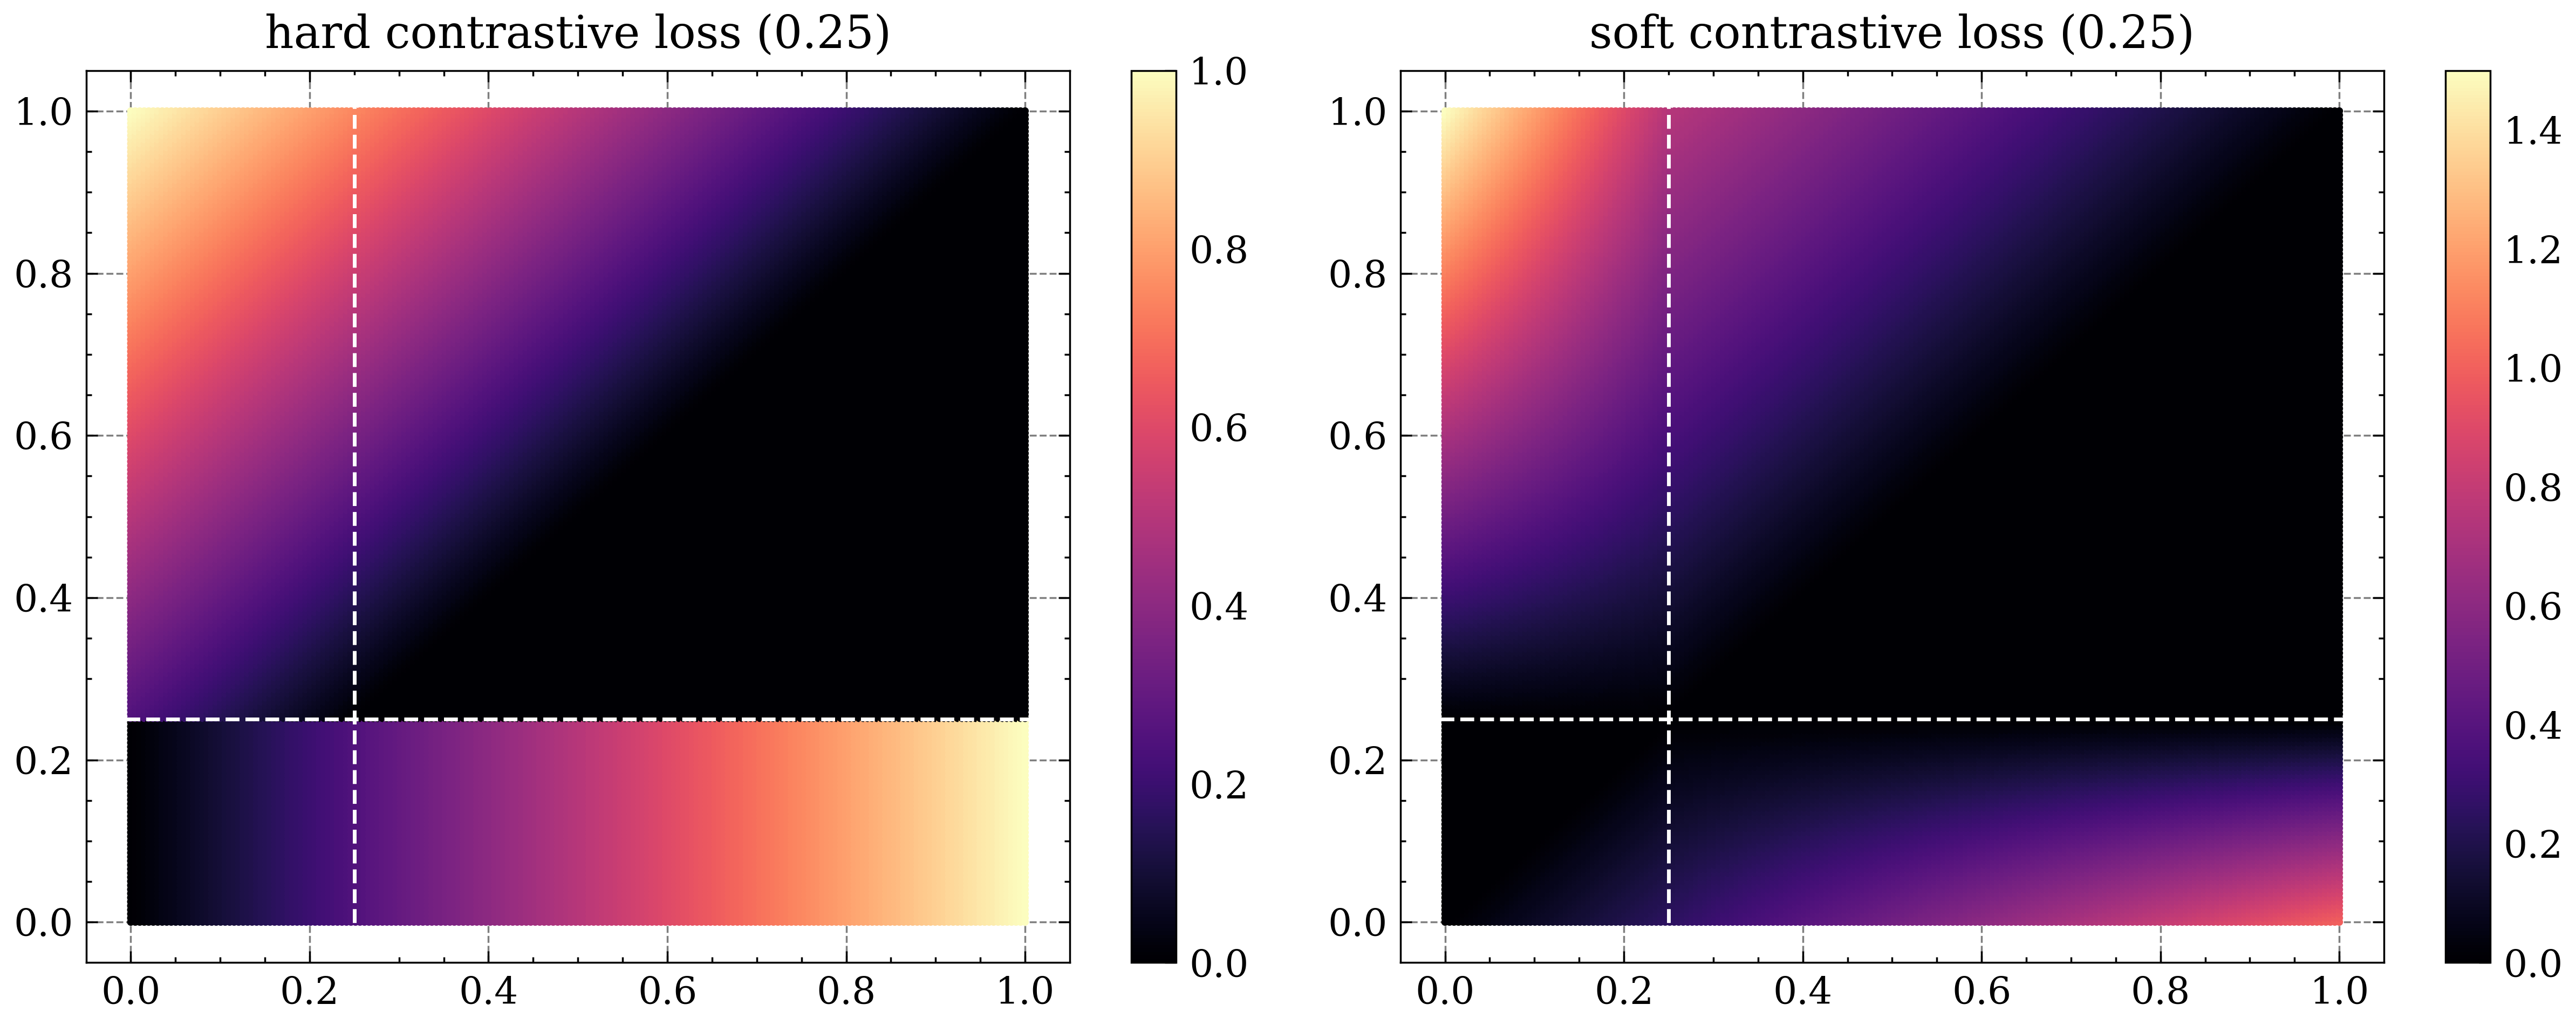

In [6]:
plt.close("all")
plt.style.use(["science", "no-latex", "grid"])
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), dpi=500)
p = ax1.scatter(z2, z1, c=hard_loss, vmin=min(hard_loss), vmax=max(hard_loss), s=1)
ax1.set_title("hard contrastive loss (0.25)")
ax1.axhline(y=threshold, color="white", linestyle="--")
ax1.axvline(x=threshold, color="white", linestyle="--")
plt.colorbar(p, ax=ax1)

p = ax2.scatter(z2, z1, c=soft_loss, vmin=min(soft_loss), vmax=max(soft_loss), s=1)

ax2.set_title("soft contrastive loss (0.25)")
ax2.axhline(y=threshold, color="white", linestyle="--")
ax2.axvline(x=threshold, color="white", linestyle="--")
plt.colorbar(p, ax=ax2)

fig.tight_layout()
plt.show()